## Networks - Final Project
### Transportation networks

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import openmatrix as omx
import igraph as ig
from queue import PriorityQueue
import random
import networkx as nx
from scipy.optimize import minimize
import itertools
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from scipy.misc import derivative
from pytrans.UrbanNetworkAnalysis import TransportationNetworks as tn

### 1. Social optimum and user equilibrium

In [ ]:
def BPR(t0, xa, ca, alpha, beta):
    ta = t0*(1+alpha*(xa/ca)**beta)
    return ta

In [ ]:
def calculateZ(theta, network, SO):
    z = 0
    for linkKey, linkVal in network.items():
        t0 = linkVal['t0']
        ca = linkVal['capa']
        beta = linkVal['beta']
        alpha = linkVal['alpha']
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        
        if SO == False:
            z += integrate.quad(lambda x: BPR(t0, x, ca, alpha, beta), 0, flow+theta*(aux-flow))[0]
        elif SO == True:
            z += list(map(lambda x : x * BPR(t0, x, ca, alpha, beta), [flow+theta*(aux-flow)]))[0]
    return z

In [ ]:
linkVal['beta']

16.83

In [ ]:
linkVal['alpha']

1.96714974076942e-67

In [ ]:
def lineSearch(network, SO):
    theta = minimize_scalar(lambda x: calculateZ(x, network, SO), bounds = (0,1), method = 'Bounded')
    return theta.x

In [ ]:
# Load data

directory = ".\\Data\\TransportationNetworks\\Barcelona\\"
link_file = '{}Barcelona_net.tntp'.format(directory)
trip_file = '{}Barcelona_trips.tntp'.format(directory)
node_file = None

In [ ]:
# Set objective and Open a network

SO = False # True - System optimum, False - User equilibrium
barcelona = tn.Network(link_file, trip_file, node_file, SO)

In [ ]:
# Perform the All-or-Nothing (AoN) assignment based on the free flow travel time (t0) and calculate the link performance (t1) based on the link volume (x0)

## initialization

# define output variables, network and fwResult
network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
           'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
           'auxiliary':[], 'cost':[]} for (u, v, d) in barcelona.graph.edges(data=True)}

fwResult = {'theta':[], 'z':[]}

# initial all-or-nothing assignment and update link travel time(cost)
barcelona.all_or_nothing_assignment()
barcelona.update_linkcost()

for linkKey, linkVal in network.items():
    linkVal['cost'].append(barcelona.graph[linkKey[0]][linkKey[1]]['weight'])
    linkVal['auxiliary'].append(barcelona.graph[linkKey[0]][linkKey[1]]['object'].vol)
    linkVal['flow'].append(barcelona.graph[linkKey[0]][linkKey[1]]['object'].vol)

In [ ]:
## iterations

iterNum=0
iteration = True
while iteration:
    iterNum += 1
    barcelona.all_or_nothing_assignment()
    barcelona.update_linkcost()
    
    # set auxiliary flow using updated link flow
    for linkKey, linkVal in network.items():
        linkVal['auxiliary'].append(barcelona.graph[linkKey[0]][linkKey[1]]['object'].vol)
        
    # getting optimal move size (theta)
    theta = lineSearch(network, SO)
    fwResult['theta'].append(theta)
    
    # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
    for linkKey, linkVal in network.items():
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        linkVal['flow'].append(flow + theta*(aux-flow))
        
        barcelona.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
        barcelona.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
        
    # update link travel time
    barcelona.update_linkcost()
    
    # calculate objective function value
    z=0
    for linkKey, linkVal in network.items():
        linkVal['cost'].append(barcelona.graph[linkKey[0]][linkKey[1]]['weight'])
        totalcost = barcelona.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
        z+=totalcost
        
    fwResult['z'].append(z)        
        
    # convergence test
    if iterNum == 1:
        iteration = True
    else:
        if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
            iteration = False

In [ ]:
# Result

df = pd.DataFrame(columns=['source', 'target', 'vol'])

# Iterate through the edges of the graph and add data to the dataframe
for (u, v, d) in barcelona.graph.edges(data=True):
    row = {'u': u, 'v': v, 'vol': d['object'].vol}
    df = df.append(row, ignore_index=True)

# Print the resulting dataframe
df

C:\Users\codiz\AppData\Local\Temp\ipykernel_6912\1491810929.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\codiz\AppData\Local\Temp\ipykernel_6912\1491810929.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\codiz\AppData\Local\Temp\ipykernel_6912\1491810929.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\codiz\AppData\Local\Temp\ipykernel_6912\1491810929.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\codiz\AppData\Local\Temp\ipyker

source target          vol     u     v
0       NaN    NaN  1108.708224     1   290
1       NaN    NaN  1137.400857     1   307
2       NaN    NaN     0.000020     1   316
3       NaN    NaN  2249.027004   290     1
4       NaN    NaN  1774.101994   290   276
...     ...    ...          ...   ...   ...
2517    NaN    NaN     0.000000  1000  1002
2518    NaN    NaN  1192.605858  1001   995
2519    NaN    NaN    13.269993  1001  1002
2520    NaN    NaN     0.000000  1001  1004
2521    NaN    NaN     0.000832  1012   904

[2522 rows x 5 columns]

### 2. Braess Paradox

In [ ]:
barcelona_trips = "Barcelona_trips.tntp.txt"

with open('Barcelona_trips.tntp.txt', 'r') as f:
    data = f.readlines()

table = []
for line in data:
    if 'Origin' in line:
        origin = line.strip().split()[1]

    else:
        for destination in line.strip().split(';')[:-1]:
            destination_number, weight = destination.split(':')
            table.append([origin, destination_number.strip(), weight.strip()])

trips = pd.DataFrame(table, columns=['origin', 'destination', 'demand'])


In [ ]:
net = "Barcelona_net.tntp.txt"
net = pd.read_csv(net, skiprows=8, sep='\t').drop(["~",";"], axis=1)

net


init_node  term_node  capacity    length  free_flow_time             b  \
0             1        290         1  1.083333        1.083333  0.000000e+00   
1             1        307         1  1.083333        1.083333  0.000000e+00   
2             1        316         1  1.083333        1.083333  0.000000e+00   
3             2        302         1  1.666667        1.666667  0.000000e+00   
4             2        304         1  1.666667        1.666667  0.000000e+00   
...         ...        ...       ...       ...             ...           ...   
2517       1019        873         1  0.666667        0.666667  4.698374e-19   
2518       1019       1018         1  0.200000        0.200000  1.951000e-18   
2519       1020         74         1  0.833333        0.833333  0.000000e+00   
2520       1020        304         1  2.000000        2.000000  2.853196e-19   
2521       1020        306         1  1.000000        1.000000  2.853196e-19   

      power  speed  toll  link_type  
0     0.000      0     0          9  
1     0.000      0     0          9  
2     0.000      0     0          9  
3     0.000      0     0          9  
4     0.000      0     0          9  
...     ...    ...   ...        ...  
2517  4.734      0     0          1  
2518  4.446      0     0          1  
2519  0.000      0     0          9  
2520  4.734      0     0          1  
2521  4.734      0     0          1  

[2522 rows x 10 columns]

In [ ]:
# Flow user eq.

flow_ue = pd.read_csv('Barcelona_flow_nash.csv', index_col=0)
flow_ue.columns = ['source','target','volume_ue']
flow_ue = flow_ue.sort_values(['source', 'target'])
flow_ue

source  target    volume_ue
0          1     290  1108.708224
1          1     307  1137.400857
2          1     316     0.000020
14         2     302     0.000000
15         2     304     0.000000
...      ...     ...          ...
1269    1019     873  6396.337046
1270    1019    1018  1318.914755
1015    1020      74  1077.668238
1016    1020     304     0.000452
1017    1020     306  4210.057118

[2522 rows x 3 columns]

In [ ]:
# Flow user eq.

flow_so = pd.read_csv('Barcelona_flow_optimum.csv', index_col=0)
flow_so = flow_so.drop(['source','target'], axis=1)
flow_so.columns = ['volume_so','source','target',]
flow_so = flow_so.sort_values(['source', 'target'])
flow_so


volume_so  source  target
0     1104.766486       1     290
1     1141.601792       1     307
2        0.064515       1     316
14       0.000000       2     302
15       0.000000       2     304
...           ...     ...     ...
1269  6353.153189    1019     873
1270  1323.397860    1019    1018
1015  1077.923260    1020      74
1016     1.438329    1020     304
1017  4195.574152    1020     306

[2522 rows x 3 columns]

In [ ]:
# Data user equilibrium

data = pd.concat([net,flow_ue[['volume_ue']]], axis=1)
data = pd.concat([data,flow_so[['volume_so']]], axis=1)
data['volume_ue_per'] = data['volume_ue']#/data['volume_ue'].sum()
data['volume_so_per'] = data['volume_so']#/data['volume_so'].sum()
data

init_node  term_node  capacity    length  free_flow_time             b  \
0             1        290         1  1.083333        1.083333  0.000000e+00   
1             1        307         1  1.083333        1.083333  0.000000e+00   
2             1        316         1  1.083333        1.083333  0.000000e+00   
3             2        302         1  1.666667        1.666667  0.000000e+00   
4             2        304         1  1.666667        1.666667  0.000000e+00   
...         ...        ...       ...       ...             ...           ...   
2517       1019        873         1  0.666667        0.666667  4.698374e-19   
2518       1019       1018         1  0.200000        0.200000  1.951000e-18   
2519       1020         74         1  0.833333        0.833333  0.000000e+00   
2520       1020        304         1  2.000000        2.000000  2.853196e-19   
2521       1020        306         1  1.000000        1.000000  2.853196e-19   

      power  speed  toll  link_type    volume_ue    volume_so  volume_ue_per  \
0     0.000      0     0          9  1108.708224  1104.766486    1108.708224   
1     0.000      0     0          9  1137.400857  1141.601792    1137.400857   
2     0.000      0     0          9     0.000020     0.064515       0.000020   
3     0.000      0     0          9  2249.027004  2271.433560    2249.027004   
4     0.000      0     0          9  1774.101994  1823.013725    1774.101994   
...     ...    ...   ...        ...          ...          ...            ...   
2517  4.734      0     0          1     0.000000     0.000000       0.000000   
2518  4.446      0     0          1  1192.605858  1192.286575    1192.605858   
2519  0.000      0     0          9    13.269993    13.247530      13.269993   
2520  4.734      0     0          1     0.000000     0.000000       0.000000   
2521  4.734      0     0          1     0.000832     0.365041       0.000832   

      volume_so_per  
0       1104.766486  
1       1141.601792  
2          0.064515  
3       2271.433560  
4       1823.013725  
...             ...  
2517       0.000000  
2518    1192.286575  
2519      13.247530  
2520       0.000000  
2521       0.365041  

[2522 rows x 14 columns]

In [ ]:
data['latency_ue'] = (data['length'] / 60.0) * (1.0 + 0.2 * np.power((data['volume_ue_per'] / data['capacity']), 10.0))
data['latency_so'] = (data['length'] / 60.0) * (1.0 + 0.2 * np.power((data['volume_so_per'] / data['capacity']), 10.0))
data['cost_ue'] = data['latency_ue'] * data['volume_ue_per']
data['cost_so'] = data['latency_so'] * data['volume_so_per']
data

init_node  term_node  capacity    length  free_flow_time             b  \
0             1        290         1  1.083333        1.083333  0.000000e+00   
1             1        307         1  1.083333        1.083333  0.000000e+00   
2             1        316         1  1.083333        1.083333  0.000000e+00   
3             2        302         1  1.666667        1.666667  0.000000e+00   
4             2        304         1  1.666667        1.666667  0.000000e+00   
...         ...        ...       ...       ...             ...           ...   
2517       1019        873         1  0.666667        0.666667  4.698374e-19   
2518       1019       1018         1  0.200000        0.200000  1.951000e-18   
2519       1020         74         1  0.833333        0.833333  0.000000e+00   
2520       1020        304         1  2.000000        2.000000  2.853196e-19   
2521       1020        306         1  1.000000        1.000000  2.853196e-19   

      power  speed  toll  link_type    volume_ue    volume_so  volume_ue_per  \
0     0.000      0     0          9  1108.708224  1104.766486    1108.708224   
1     0.000      0     0          9  1137.400857  1141.601792    1137.400857   
2     0.000      0     0          9     0.000020     0.064515       0.000020   
3     0.000      0     0          9  2249.027004  2271.433560    2249.027004   
4     0.000      0     0          9  1774.101994  1823.013725    1774.101994   
...     ...    ...   ...        ...          ...          ...            ...   
2517  4.734      0     0          1     0.000000     0.000000       0.000000   
2518  4.446      0     0          1  1192.605858  1192.286575    1192.605858   
2519  0.000      0     0          9    13.269993    13.247530      13.269993   
2520  4.734      0     0          1     0.000000     0.000000       0.000000   
2521  4.734      0     0          1     0.000832     0.365041       0.000832   

      volume_so_per    latency_ue    latency_so       cost_ue       cost_so  
0       1104.766486  1.013476e+28  9.780156e+27  1.123649e+31  1.080479e+31  
1       1141.601792  1.308508e+28  1.357648e+28  1.488298e+31  1.549894e+31  
2          0.064515  1.805556e-02  1.805556e-02  3.661713e-07  1.164849e-03  
3       2271.433560  1.839392e+31  2.031084e+31  4.136841e+34  4.613472e+34  
4       1823.013725  1.715984e+30  2.252303e+30  3.044331e+33  4.105980e+33  
...             ...           ...           ...           ...           ...  
2517       0.000000  1.111111e-02  1.111111e-02  0.000000e+00  0.000000e+00  
2518    1192.286575  3.880415e+27  3.870038e+27  4.627805e+30  4.614195e+30  
2519      13.247530  4.703319e+08  4.624306e+08  6.241301e+09  6.126064e+09  
2520       0.000000  3.333333e-02  3.333333e-02  0.000000e+00  0.000000e+00  
2521       0.365041  1.666667e-02  1.666681e-02  1.386127e-05  6.084068e-03  

[2522 rows x 18 columns]

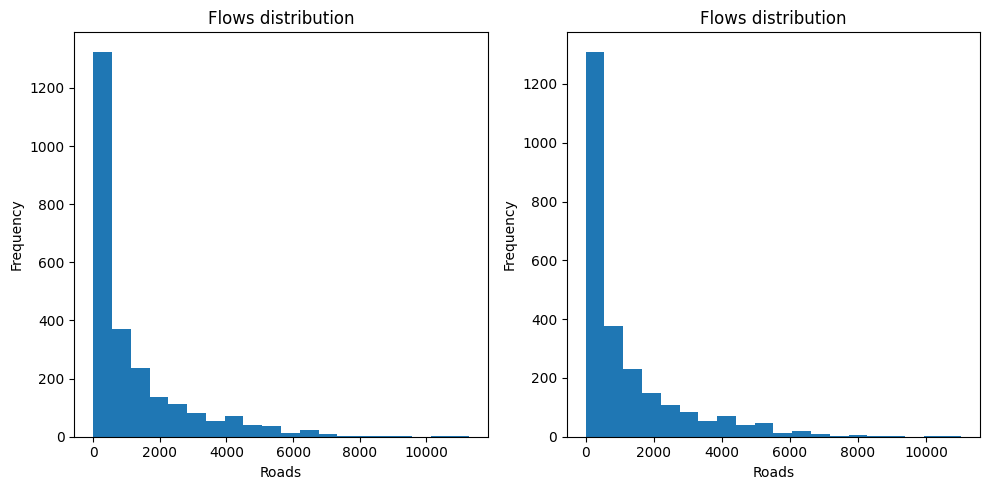

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot the first histogram
axes[0].hist(data['volume_ue_per'], bins=20)
axes[0].set_xlabel('Roads')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Flows distribution')

# Plot the second histogram
axes[1].hist(data['volume_so_per'], bins=20)
axes[1].set_xlabel('Roads')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Flows distribution')

# Adjust the layout of the subplots
plt.tight_layout()

# Display the grid
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

b1 = go.Box(x=data['volume_ue'],
    name='User Equilibium',
    marker_color='darkblue')
b2 = go.Box(x=data['volume_so'],
    name='Social Optimum',
    marker_color='grey')


fig = make_subplots(rows=2, cols=1)
fig.append_trace(b1, row = 1, col = 1)
fig.append_trace(b2, row = 2, col = 1)


fig.update_traces(orientation='h')
fig.update_layout(showlegend=False, title= '<b>Flows distribution<b>', title_x=0.5, font_color='black', title_font_size=16)
fig.show()

In [ ]:
data.describe()

init_node    term_node  capacity       length  free_flow_time  \
count  2522.000000  2522.000000    2522.0  2522.000000     2522.000000   
mean    552.013481   553.138779       1.0     0.645347        0.645347   
std     292.815176   292.902726       0.0     1.650823        1.650823   
min       1.000000     1.000000       1.0     0.051429        0.051429   
25%     313.000000   313.250000       1.0     0.188571        0.188571   
50%     560.000000   562.000000       1.0     0.373333        0.373333   
75%     821.000000   822.000000       1.0     0.778333        0.778333   
max    1020.000000  1020.000000       1.0    55.000000       55.000000   

                  b        power   speed    toll    link_type     volume_ue  \
count  2.522000e+03  2522.000000  2522.0  2522.0  2522.000000   2522.000000   
mean   8.789544e-12     4.245316     0.0     0.0     2.792228   1143.493479   
std    1.029939e-10     3.607161     0.0     0.0     3.336189   1579.676856   
min    0.000000e+00     0.000000     0.0     0.0     1.000000      0.000000   
25%    1.967150e-67     4.217250     0.0     0.0     1.000000     17.578329   
50%    1.087306e-18     4.446000     0.0     0.0     1.000000    505.605724   
75%    7.010272e-18     4.924000     0.0     0.0     1.000000   1555.835047   
max    2.176649e-09    16.830000     0.0     0.0     9.000000  11267.927184   

          volume_so  volume_ue_per  volume_so_per    latency_ue    latency_so  \
count   2522.000000    2522.000000    2522.000000  2.522000e+03  2.522000e+03   
mean    1144.187919    1143.493479    1144.187919  3.998813e+34  3.219269e+34   
std     1570.659695    1579.676856    1570.659695  6.838588e+35  5.580533e+35   
min        0.000000       0.000000       0.000000  8.888889e-04  8.888889e-04   
25%       23.187220      17.578329      23.187220  2.498671e+09  3.450473e+10   
50%      508.508497     505.605724     508.508497  1.344366e+24  1.500625e+24   
75%     1584.583461    1555.835047    1584.583461  1.120685e+29  1.242537e+29   
max    11035.484629   11267.927184   11035.484629  2.052985e+37  1.830453e+37   

            cost_ue       cost_so  
count  2.522000e+03  2.522000e+03  
mean   3.666411e+38  2.885360e+38  
std    6.857678e+39  5.495287e+39  
min    0.000000e+00  0.000000e+00  
25%    4.538357e+10  8.025107e+11  
50%    7.064522e+26  7.975432e+26  
75%    1.728673e+32  2.040214e+32  
max    2.313289e+41  1.839293e+41

In [ ]:
# Cost and PoA

cost_ue = data['cost_ue'].sum() # User eq
cost_so = data['cost_so'].sum() # Social op
poa = cost_ue/cost_so

print("Cost user equilibrium: "+str(cost_ue), "\n","Cost social optimum: "+str(cost_so),"\n", "PoA: "+str(poa))

Cost user equilibrium: 9.246687685701464e+41 
 Cost social optimum: 7.276877376349842e+41 
 PoA: 1.2706944486591996


In [ ]:
# Network

g = ig.Graph.TupleList(data.itertuples(index=False), directed=True, weights=False, edge_attrs=["capacity","length","free_flow_time","b","power","speed","toll",
                                                                                                  "link_type", "volume_ue","volume_so"])

zone_indices = list(range(1,110))

colors = ["darkred" if i in zone_indices else "darkblue" for i in range(g.vcount())]
shapes = ["square" if i in zone_indices else "circle" for i in range(g.vcount())]
g.vs["color"] = colors
g.vs["shape"] = shapes

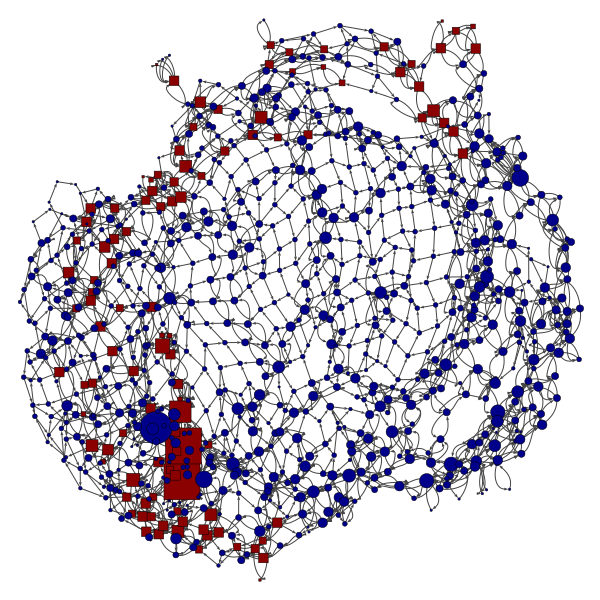

In [ ]:
degree = g.degree()
g.vs["degree"] = degree

# calculate vertex sizes based on degree

sizes = [d * 1.2 for d in degree]

#adjust layout 
layout = g.layout("kamada_kawai") 

# get graph information and plot
g.summary() 
ig.plot(g, vertex_size = sizes, layout=layout, edge_arrow_size = 0.3, vertex_frame_width=0.5)

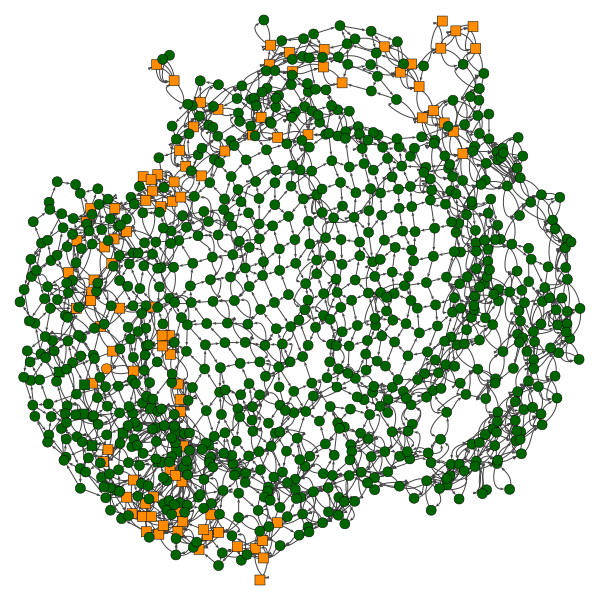

In [ ]:


g.vs['color'] = ['darkorange' if a in sg.vs.indices else 'darkgreen' for a in g.vs.indices]

# here's what our lil' graph looks like in terms of the entire graph!
ig.plot(g,  vertex_size = 10, layout=layout, edge_arrow_size = 0.3, vertex_frame_width=0.5)

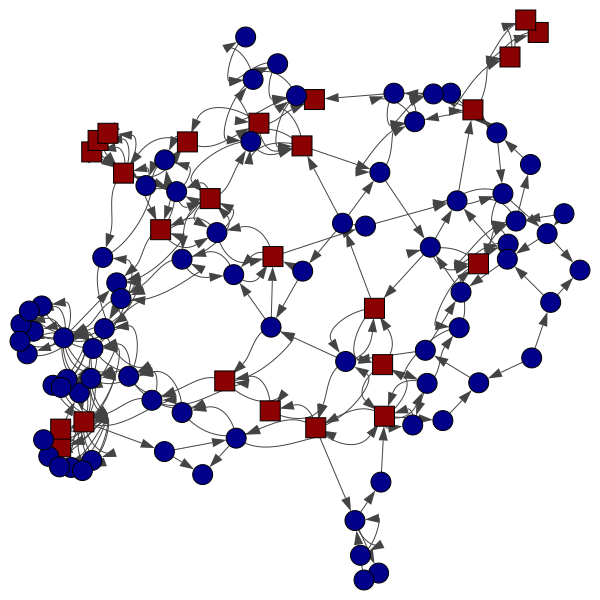

In [ ]:
# Subgraph

random.seed(42)

sg = g.subgraph(g.neighborhood(1, order= 5))
sg_df = sg.get_edge_dataframe()

# and here it is on its own!
random.seed(5)
ig.plot(sg)

In [ ]:
# Dataframe subgraph

sg_df

source  target  capacity    length  free_flow_time             b  \
edge ID                                                                     
0             0       1         1  1.083333        1.083333  0.000000e+00   
1             0       2         1  1.083333        1.083333  0.000000e+00   
2             0       3         1  1.083333        1.083333  0.000000e+00   
3             1       0         1  1.083333        1.083333  0.000000e+00   
4             1      58         1  0.240000        0.240000  2.492048e-65   
...         ...     ...       ...       ...             ...           ...   
252          96      98         1  0.173333        0.173333  7.010272e-18   
253          97      63         1  0.200000        0.200000  1.951000e-18   
254          97      93         1  0.373333        0.373333  7.010272e-18   
255          99      28         1  0.200000        0.200000  1.951000e-18   
256          99      92         1  0.186667        0.186667  7.010272e-18   

          power  speed  toll  link_type    volume_ue    volume_so  
edge ID                                                            
0         0.000      0     0          9  1108.708224  1104.766486  
1         0.000      0     0          9  1137.400857  1141.601792  
2         0.000      0     0          9     0.000020     0.064515  
3         0.000      0     0          9     0.000000     0.000000  
4        16.830      0     0          1  3966.960432  3863.949645  
...         ...    ...   ...        ...          ...          ...  
252       4.446      0     0          1     0.000030     0.095299  
253       4.446      0     0          1  1261.196021  1270.314370  
254       4.446      0     0          1  1094.809199  1109.876582  
255       4.446      0     0          1  2862.203739  2967.269143  
256       4.446      0     0          1   774.472652   777.150136  

[257 rows x 12 columns]

In [ ]:
sg_df['volume_ue_per'] = sg_df['volume_ue']#/sg_df['volume_ue'].sum()
sg_df['volume_so_per'] = sg_df['volume_so']#/sg_df['volume_so'].sum()
sg_df['latency_ue'] = (sg_df['length'] / 60.0) * (1.0 + 0.2 * np.power((sg_df['volume_ue_per'] / sg_df['capacity']), 10.0))
sg_df['latency_so'] = (sg_df['length'] / 60.0) * (1.0 + 0.2 * np.power((sg_df['volume_so_per'] / sg_df['capacity']), 10.0))
sg_df['cost_ue'] = sg_df['latency_ue'] * sg_df['volume_ue_per']
sg_df['cost_so'] = sg_df['latency_so'] * sg_df['volume_so_per']
sg_df

source  target  capacity    length  free_flow_time             b  \
edge ID                                                                     
0             0       1         1  1.083333        1.083333  0.000000e+00   
1             0       2         1  1.083333        1.083333  0.000000e+00   
2             0       3         1  1.083333        1.083333  0.000000e+00   
3             1       0         1  1.083333        1.083333  0.000000e+00   
4             1      58         1  0.240000        0.240000  2.492048e-65   
...         ...     ...       ...       ...             ...           ...   
252          96      98         1  0.173333        0.173333  7.010272e-18   
253          97      63         1  0.200000        0.200000  1.951000e-18   
254          97      93         1  0.373333        0.373333  7.010272e-18   
255          99      28         1  0.200000        0.200000  1.951000e-18   
256          99      92         1  0.186667        0.186667  7.010272e-18   

          power  speed  toll  link_type    volume_ue    volume_so  \
edge ID                                                             
0         0.000      0     0          9  1108.708224  1104.766486   
1         0.000      0     0          9  1137.400857  1141.601792   
2         0.000      0     0          9     0.000020     0.064515   
3         0.000      0     0          9     0.000000     0.000000   
4        16.830      0     0          1  3966.960432  3863.949645   
...         ...    ...   ...        ...          ...          ...   
252       4.446      0     0          1     0.000030     0.095299   
253       4.446      0     0          1  1261.196021  1270.314370   
254       4.446      0     0          1  1094.809199  1109.876582   
255       4.446      0     0          1  2862.203739  2967.269143   
256       4.446      0     0          1   774.472652   777.150136   

         volume_ue_per  volume_so_per    latency_ue    latency_so  \
edge ID                                                             
0          1108.708224    1104.766486  1.013476e+28  9.780156e+27   
1          1137.400857    1141.601792  1.308508e+28  1.357648e+28   
2             0.000020       0.064515  1.805556e-02  1.805556e-02   
3             0.000000       0.000000  1.805556e-02  1.805556e-02   
4          3966.960432    3863.949645  7.720913e+32  5.934779e+32   
...                ...            ...           ...           ...   
252           0.000030       0.095299  2.888889e-03  2.888889e-03   
253        1261.196021    1270.314370  6.787888e+27  7.294925e+27   
254        1094.809199    1109.876582  3.078647e+27  3.529575e+27   
255        2862.203739    2967.269143  2.459882e+31  3.527590e+31   
256         774.472652     777.150136  4.830659e+25  5.000285e+25   

              cost_ue       cost_so  
edge ID                              
0        1.123649e+31  1.080479e+31  
1        1.488298e+31  1.549894e+31  
2        3.661713e-07  1.164849e-03  
3        0.000000e+00  0.000000e+00  
4        3.062856e+36  2.293169e+36  
...               ...           ...  
252      8.654328e-08  2.753079e-04  
253      8.560857e+30  9.266848e+30  
254      3.370531e+30  3.917392e+30  
255      7.040682e+34  1.046731e+35  
256      3.741213e+28  3.885972e+28  

[257 rows x 18 columns]

In [ ]:
sg.ecount()

257

In [ ]:
# Cost and PoA

cost_ue_sg = sg_df['cost_ue'].sum() # User eq
cost_so_sg = sg_df['cost_so'].sum() # Social op
poa_sg = cost_ue/cost_so

print("Cost user equilibrium: "+str(cost_ue_sg), "\n","Cost social optimum: "+str(cost_so_sg),"\n", "PoA: "+str(poa_sg))

Cost user equilibrium: 4.3109139857705065e+40 
 Cost social optimum: 4.1724501871900116e+40 
 PoA: 1.2706944486591996


In [ ]:
# Braess Paradox

# calculate the equilibrium when all the roads are open.

# define the number of variables
N = len(sg_df)
# generate the initial guess
random.seed(1)
rand_nums = np.random.rand(N-1)
rand_nums = np.sort(rand_nums)
init_guess = [rand_nums[0]] + [rand_nums[i]-rand_nums[i-1] for i in range(1, N-1)] + [1-rand_nums[-1]]


# define the bounds for the variables
bounds = [(0, 1)] * N

# define the constraint that the variables must sum up to one
def constraint(x):
    return np.sum(x) - 1

def calculate_integral(x, d, capacity):
    return sum((d * x**11)/(1925*capacity**10) + (d * x) / 60)

res = minimize(calculate_integral, init_guess, args=(sg_df['length'].values, sg_df['capacity'].values), bounds=bounds, constraints={'type': 'eq', 'fun': constraint})

optimal_eq_val = res.fun

print("Initial cost: "+str(optimal_eq_val))

Initial cost: 0.001468108872918006


### Braess Paradox algorithm

In [ ]:
# %%
# what happens if we close one edge at a time?
N = len(sg_df) - 1
remove_one_edge = list(itertools.combinations(range(N+1), N))

# define the bounds for the variables
bounds = [(0, 1)] * N

# generate the initial guess
random.seed(1)
rand_nums = np.random.rand(N-1)
rand_nums = np.sort(rand_nums)
init_guess = [rand_nums[0]] + [rand_nums[i]-rand_nums[i-1] for i in range(1, N-1)] + [1-rand_nums[-1]]

funs = []
for i in remove_one_edge:
    i = list(i)
    random.seed(1)
    res = minimize(calculate_integral, init_guess, args=(sg_df.loc[i]['length'].values, sg_df.loc[i]['capacity'].values), bounds=bounds, constraints={'type': 'eq', 'fun': constraint})
    funs.append(res.fun)

# Here are the list of edges where we are omitting one and result in a lower total cost function:
print(pd.Series(remove_one_edge)[funs < optimal_eq_val])

29    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
72    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
dtype: object


In [ ]:
0.001468108872918006 - 0.0013748917748918326


9.321709802617337e-05

In [ ]:
funs[val]

0.0013748917748918326

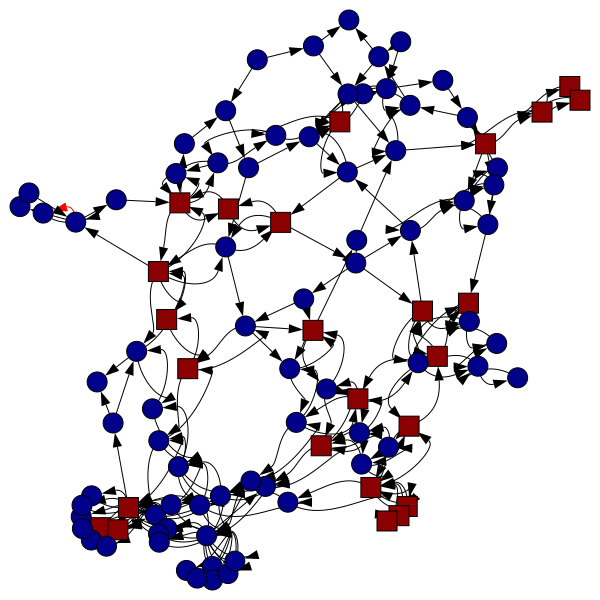

In [ ]:
#identify the unnecessary edge from the random combination whose Eq value is less than the one with all edges
val = random.sample(list(pd.Series(remove_one_edge)[funs < optimal_eq_val].index.values), 1)[0]
bad_edge = set(range(N+1)) - set(pd.Series(remove_one_edge)[funs < optimal_eq_val][val])

sg.es["color"] = ["black" if i != list(bad_edge)[0] else "red" for i in list(range(N+1))]

#plot full graph, identifying unecessary edge:
ig.plot(sg)


In [ ]:
#calculate relative welfare gain from closing this edge:
(optimal_eq_val-  funs[val])*100/optimal_eq_val